# Random Forest Regression model to estimate the number of people in rooms 

In [51]:
import pandas as pd
import numpy as np
import os
import re

In [52]:
def room_division(dataRoom):
    """Divide entries on rooms, not on AP number"""
    
    Ap = "AP-AULA"
    dataRoom = dataRoom[dataRoom["name_ap"].notnull()]
    dataRoom = dataRoom[dataRoom["name_ap"].str.contains(Ap)]
    rooms = pd.DataFrame()
    max_l = max([len(sublist.split("-")) for sublist in dataRoom["name_ap"]])
    if max_l == 2:
        rooms[["AP", "Room"]] = dataRoom["name_ap"].str.split("-", expand=True)
    elif max_l == 3:
        rooms[["AP", "Room", "APnum"]] = dataRoom["name_ap"].str.split("-", expand=True)
    elif max_l == 4:
        rooms[["AP", "Room", "APnum", "NaN"]] = dataRoom["name_ap"].str.split(
            "-", expand=True
        )
        rooms = rooms.drop(["NaN"], axis=1)
    elif max_l == 5:
        rooms[["AP", "Room", "APnum", "NaN", "other"]] = dataRoom["name_ap"].str.split(
            "-", expand=True
        )
        rooms = rooms.drop(["NaN", "other"])
    else:
        raise Exception("Error in dataRoom['name_ap'].str.split('-', expand=True)")

    dataRoom = pd.concat([dataRoom, rooms], axis=1)
    dataRoom = dataRoom.drop(["AP"], axis=1)
    return dataRoom

Extract the features from the dataset

In [53]:
dataset_dict = {
    "aula": [],
    "n_devices": [],
    "n_users": [],
    "snr_mean": [],
    "snr_std": [],
    "rssi_mean": [],
    "rssi_std": [],
    "ch_util_2_4_mean": [],
    "ch_util_5_mean": [],
    "noise_2_4_mean": [],
    "noise_5_mean": [],
    "n_people": []
}

path = "../data/ml_data/"
regex_aula = "(AULA.+)_"
regex_n_people = "_([0-9]+)\."


for i, file in enumerate(os.listdir(path)):
    df = pd.read_csv(path + file)
    df.drop(columns=["Unnamed: 0", "Timestamp_y", "ch_2_4", "ch_5", "class", "domain", "client_type", "code_ap"], inplace=True)
    df = room_division(df)

    aula = re.search(regex_aula, file).group(1)
    df_aula = df[df["Room"] == aula]

    if len(df_aula) == 0:
        print(f"{aula} is empty. Skipping the acquisition!")
        continue
    dataset_dict["aula"].append(aula)

    # Feature extrapolation
    df_dist_ap = df_aula.drop_duplicates(subset="APnum")
    n_devices = df_dist_ap["n_clients_2_4"].sum() + df_dist_ap["n_clients_5"].sum()
    dataset_dict["n_devices"].append(n_devices)

    df_dist_users = df_aula.drop_duplicates(subset="user_masked")
    n_users = len(df_dist_users[df_dist_users["snr"] > 20])
    dataset_dict["n_users"].append(n_users)

    snr_mean = df_aula["snr"].mean()
    dataset_dict["snr_mean"].append(snr_mean)
    snr_std = df_aula["snr"].std()
    dataset_dict["snr_std"].append(snr_std)

    rssi_mean = df_aula["rssi"].mean()
    dataset_dict["rssi_mean"].append(rssi_mean)
    rssi_std = df_aula["rssi"].std()
    dataset_dict["rssi_std"].append(rssi_std)

    ch_util_2_4_mean = df_dist_ap["ch_utilization_2_4"].mean()
    dataset_dict["ch_util_2_4_mean"].append(ch_util_2_4_mean)
    ch_util_5_mean = df_dist_ap["ch_utilization_5"].mean()
    dataset_dict["ch_util_5_mean"].append(ch_util_5_mean)

    noise_2_4_mean = df_dist_ap["noise_2_4"].mean()
    dataset_dict["noise_2_4_mean"].append(noise_2_4_mean)
    noise_5_mean = df_dist_ap["noise_5"].mean()
    dataset_dict["noise_5_mean"].append(noise_5_mean)


    x = re.search(regex_n_people, file)
    n_people = int(x.group(1))
    dataset_dict["n_people"].append(n_people)

In [54]:
dataset = pd.DataFrame.from_dict(dataset_dict)
dataset.head()

,aula,n_devices,n_users,snr_mean,snr_std,rssi_mean,rssi_std,ch_util_2_4_mean,ch_util_5_mean,noise_2_4_mean,noise_5_mean,n_people
0,AULA3I,3.0,2,34.000000,5.567764,-57.666667,5.507571,11.666667,15.000000,-90.333333,-90.333333,2
1,AULA7S,123.0,84,42.611570,7.513734,-51.115702,6.344538,38.333333,8.333333,-86.500000,-93.666667,127
2,AULA3P,122.0,87,40.188034,6.497920,-51.393162,5.997064,32.500000,27.500000,-84.500000,-92.250000,111
3,AULAR2,183.0,112,36.335196,7.321620,-53.027933,6.093310,37.750000,5.500000,-81.000000,-90.500000,150
4,AULA3I,6.0,4,34.800000,4.438468,-57.400000,4.449719,15.333333,5.333333,-93.666667,-89.666667,3


Divide regressor and regressand

In [55]:
y = dataset["n_people"].to_numpy()
dataset.drop(["aula", "n_people"], axis=1, inplace=True)
X = dataset.to_numpy()

Division of train and test sets

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
print("Train shape: ", X_train.shape)
print("Test shape: ", X_test.shape)

Train shape:  (61, 10)
Test shape:  (7, 10)


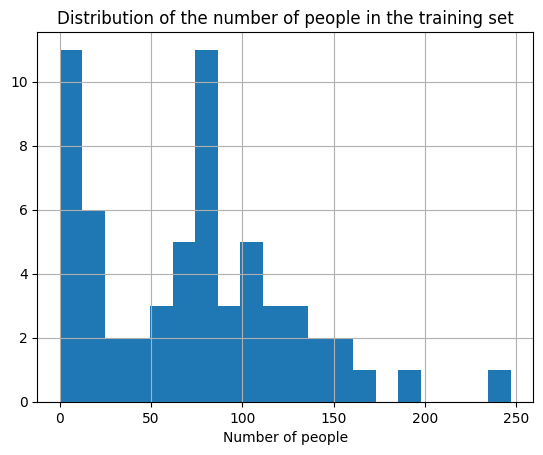

In [58]:
import matplotlib.pyplot as plt
plt.title("Distribution of the number of people in the training set")
plt.hist(y_train, bins=20)
plt.xlabel("Number of people")
plt.grid()

### Random Forest Regressor

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, ShuffleSplit

In [60]:
rf_regr = RandomForestRegressor()
fitted_rf = rf_regr.fit(X_train,y_train)

In [61]:
cv = ShuffleSplit(n_splits=3, test_size=test_size)
scores = cross_val_score(rf_regr, X, y, cv=cv)

In [62]:
print("Cross validation\nR2 score: ", scores)

Cross validation
R2 score:  [0.80804404 0.86614022 0.96370152]


In [63]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
print("R2 train: ", fitted_rf.score(X_train, y_train))
print("R2 test: ", fitted_rf.score(X_test, y_test))
print("MAE train:", mean_absolute_error(fitted_rf.predict(X_train), y_train))
print("MAE test:", mean_absolute_error(fitted_rf.predict(X_test), y_test))
print("RMSE train:", root_mean_squared_error(fitted_rf.predict(X_train), y_train))
print("RMSE test:", root_mean_squared_error(fitted_rf.predict(X_test), y_test))

R2 train:  0.9629134869333356
R2 test:  0.9462389424047142
MAE train: 5.670000000000001
MAE test: 10.652857142857146
RMSE train: 10.250865057458785
RMSE test: 12.771149965002039


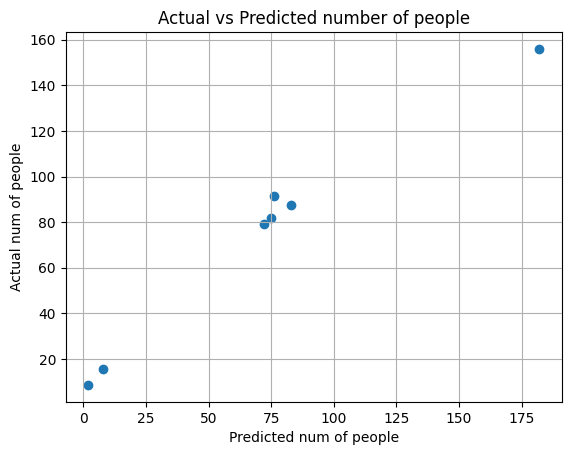

In [64]:
import matplotlib.pyplot as plt
plt.scatter(y_test, fitted_rf.predict(X_test))
plt.grid()
plt.ylabel('Actual num of people')
plt.xlabel('Predicted num of people')
plt.title('Actual vs Predicted number of people')
plt.show()

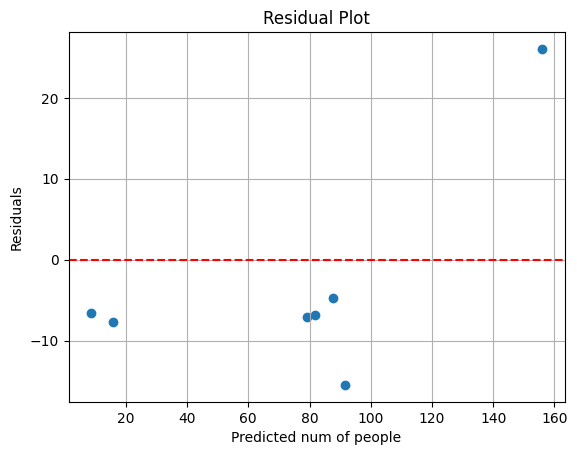

In [65]:
residuals = y_test - fitted_rf.predict(X_test)
plt.scatter(fitted_rf.predict(X_test), residuals)
plt.grid()
plt.xlabel('Predicted num of people')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

Save the model

In [ ]:
import pickle
model_path = ""
pickle.dump(fitted_rf, open(model_path, 'wb'))